# 4 CNN and AutoEncoders

We use a CNN to classify the MNIST images. We use the pytorch libary to build the CNN. 

In [1]:
# Importing torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import scipy.io as sio

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, hamming_loss

import wandb
import os

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
os.environ['WANDB_SILENT'] = 'true'

In [2]:
wandb.login()

True

In [36]:
# Checking if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Importing the MNIST dataset
# Tranform to tensor, convert to float and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## 4.1  Data visualization and Preprocessing

We do data exploration on the MNIST dataset.

### 4.1.1 Label Distribution

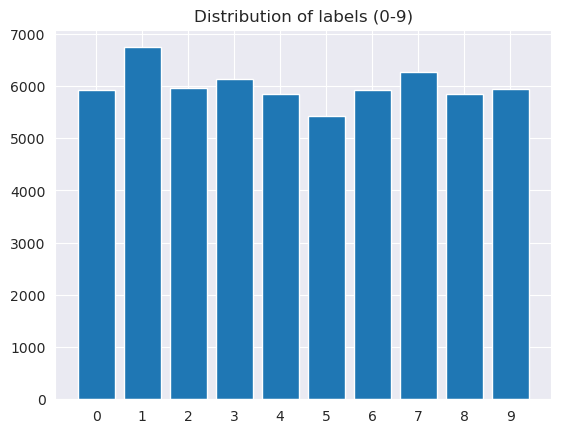

In [25]:
# Display the distribution of labels 0-9
labels = train_dataset.targets
labels = labels.numpy()
plt.bar(np.arange(10), np.bincount(labels))
plt.title('Distribution of labels (0-9)')
plt.xticks(np.arange(10))
plt.show()

### 4.1.2 Sample Visualization

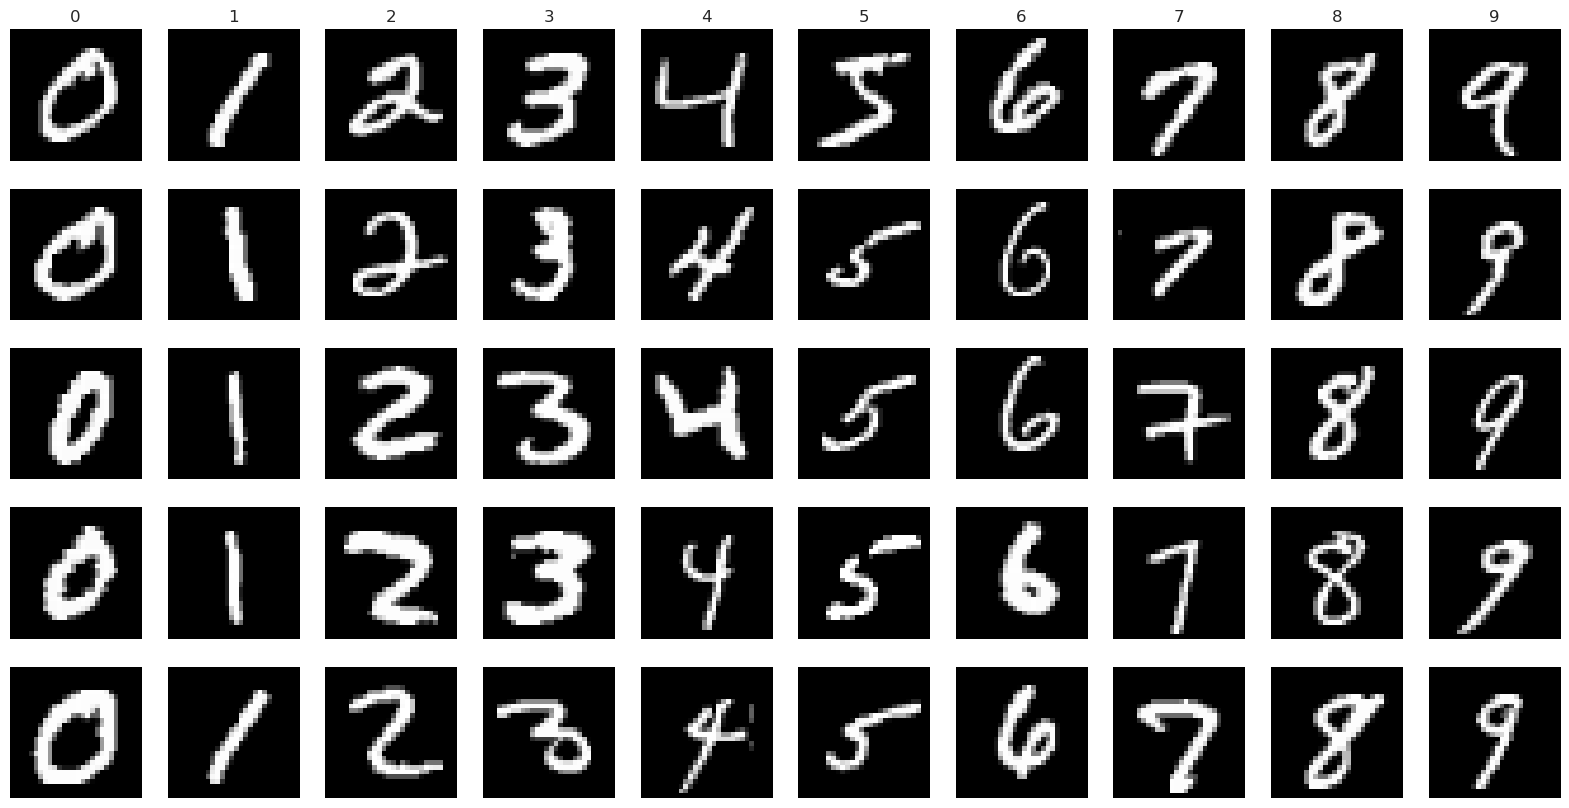

In [26]:
# Visualising the first 5 images in each class
def visualise_samples(dataset, frequency):
    fig, ax = plt.subplots(frequency, 10, figsize=(20, 10))
    labels = dataset.targets.data.numpy()
    for i in range(10):
        idx = np.where(labels == i)[0][:frequency]
        ax[0, i].set_title(dataset.targets[idx[0]].item())
        for j in range(frequency):
            ax[j, i].imshow(dataset.data[idx[j]], cmap='gray')
            ax[j, i].axis('off')


visualise_samples(train_dataset, 5)

### 4.1.3 Checking for class imbalance

In [27]:
# check and report class imbalance:
def report_imbalance(dataset):
    labels = dataset.targets.data.numpy()
    label_count = np.bincount(labels)
    print('Class imbalance:')
    for i in range(10):
        print('Label {}: {} samples'.format(i, label_count[i]))
    print('Total samples: {}'.format(len(labels)))
    print('Max samples per class: {}'.format(max(label_count)))
    print('Min samples per class: {}'.format(min(label_count)))
    print('Average samples per class: {}'.format(np.mean(label_count)))
    print('Imbalance ratio (majority/minority): {:.2f}'.format(max(label_count) / min(label_count)))


report_imbalance(train_dataset)

Class imbalance:
Label 0: 5923 samples
Label 1: 6742 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 4: 5842 samples
Label 5: 5421 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Label 9: 5949 samples
Total samples: 60000
Max samples per class: 6742
Min samples per class: 5421
Average samples per class: 6000.0
Imbalance ratio (majority/minority): 1.24


### 4.1.4 Feature Map visualization

In [28]:
# function to visualise feature map of a layer: 
def visualise_feature_map(model, image, layer):
    model.eval()

    def visualise_hook(module, input, output):
        feature_maps = output[0]
        num_feature_maps = feature_maps.size(0)
        fig, axes = plt.subplots(int((num_feature_maps + 3) // 4), 4)
        fig.suptitle('Feature maps for layer {}'.format(layer))
        fig.set_figheight(15)
        fig.set_figwidth(30)
        for ax, i in zip(axes.flatten(), range(num_feature_maps)):
            ax.imshow(feature_maps[i].detach().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()

    # Register the hook for the chosen layer
    hook = layer.register_forward_hook(visualise_hook)

    # Perform a forward pass with the input image
    with torch.no_grad():
        model(image.unsqueeze(0))

    hook.remove()

## 4.2 Model Building

Constructing a CNN to classify the MNIST images.

In [5]:
class CNN(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dropout=0.25, input_size=28):
        super(CNN, self).__init__()
        self.nn_layers = nn.ModuleList()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride)
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        # Calculate number of features after convolutions
        l = 28
        l = (l - kernel_size) // stride + 1
        l = (l - kernel_size) // stride + 1
        l = (l - 2) // 2 + 1
        self.fc1 = nn.Linear(64 * l * l, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

### Baseline CNN

In [6]:
'''
Construct and train a baseline CNN using the following architecture: 2
convolutional layers each with ReLU activation and subsequent max pooling, followed by a dropout and a fully-connected layer with softmax activation, optimized using the Adam optimizer and trained with the crossentropy loss function
'''


class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.nn_layers = nn.ModuleList()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

In [7]:
# function to train a model:
def train_model_with_logging(model, optimizer, loss_fn, train_data_loader, test_data_loader=None, epochs=10):
    progress_bar = tqdm(total=len(train_data_loader), desc='Training')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for i, (images, labels) in enumerate(train_data_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            train_accuracy += (outputs.argmax(dim=1) == labels).sum().item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=running_loss / (i + 1), epoch=epoch + 1)
            progress_bar.update()

        progress_bar.refresh()
        train_accuracy /= len(train_data_loader.dataset)
        running_loss /= len(train_data_loader)

        if test_data_loader is None:
            continue

        model.eval()
        test_loss = 0
        correct = 0
        # running predictions for confusion matrix
        running_preds = []
        running_true = []
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += loss_fn(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                running_preds.extend(list(pred.numpy().squeeze()))
                running_true.extend(list(target.numpy().squeeze()))
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('Epoch:', epoch + 1)
        print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct,
                                                                                  len(test_loader.dataset),
                                                                                  100. * correct / len(
                                                                                      test_loader.dataset)))

        # Log training/validation loss and accuracy, confusion matrices, and class specific metrics using W&B
        if wandb.run is not None:
            wandb.log({
                'val_loss': test_loss,
                'val_accuracy': 100. * correct / len(test_loader.dataset),
                'train_loss': running_loss,
                'train_accuracy': train_accuracy,
                'confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                y_true=running_true,
                                                                preds=running_preds,
                                                                class_names=np.arange(10)),
                'f1': f1_score(running_true, running_preds, average='macro', zero_division=0),
                'precision': precision_score(running_true, running_preds, average='macro', zero_division=0),
                'recall': recall_score(running_true, running_preds, average='macro', zero_division=0)
            }, step=epoch + 1)

    print('Finished Training')

In [8]:
def test_model(model, dataset):
    # Create batch loader from dataset
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    # Set model to evaluation mode
    model.eval()
    # Create empty list to store predictions
    predictions = []
    # Iterate over test batches
    for batch in data_loader:
        # Extract images and labels
        images, labels = batch
        # Forward pass
        outputs = model(images)
        # Append predictions from output
        predictions.extend(outputs.argmax(dim=1).numpy())
    return np.array(predictions)

In [33]:
cnn_baseline = CNNBaseline()

In [34]:
# Training cnn
optimizer = optim.Adam(cnn_baseline.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [35]:
train_model_with_logging(cnn_baseline, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

Training: 1883it [00:57,  3.68it/s, epoch=2, loss=1.5]                           

Epoch: 1
Val set: Average loss: 0.0465, Accuracy: 9759/10000 (98%)


Training: 3754it [01:46,  3.69it/s, epoch=3, loss=1.48]

Epoch: 2
Val set: Average loss: 0.0464, Accuracy: 9793/10000 (98%)


Training: 5633it [02:33,  6.53it/s, epoch=4, loss=1.48]

Epoch: 3
Val set: Average loss: 0.0464, Accuracy: 9789/10000 (98%)


Training: 7506it [03:27,  4.95it/s, epoch=5, loss=1.49]

Epoch: 4
Val set: Average loss: 0.0464, Accuracy: 9778/10000 (98%)


Training: 9375it [04:21, 35.84it/s, epoch=5, loss=1.48]

Epoch: 5
Val set: Average loss: 0.0463, Accuracy: 9816/10000 (98%)

Finished Training


In [36]:
# copy the test data and reshape it
predicted_labels = test_model(cnn_baseline, test_dataset)
true_labels = test_dataset.targets.numpy()
print('Classification report:')
print(classification_report(true_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.97      0.98       892
           6       1.00      0.96      0.98       958
           7       0.97      0.98      0.98      1028
           8       1.00      0.96      0.98       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


In [80]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:      7     2     1     0


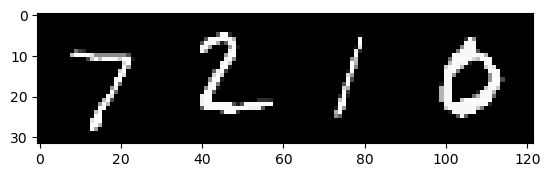

In [82]:
# print images
plt.imshow(torchvision.utils.make_grid(images[:4]).numpy().transpose(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{np.arange(10)[labels[j]]:5}' for j in range(4)))

In [83]:
outputs = cnn_baseline(images)
_, preds = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % preds[j].item() for j in range(4)))

Predicted:      7     2     1     0


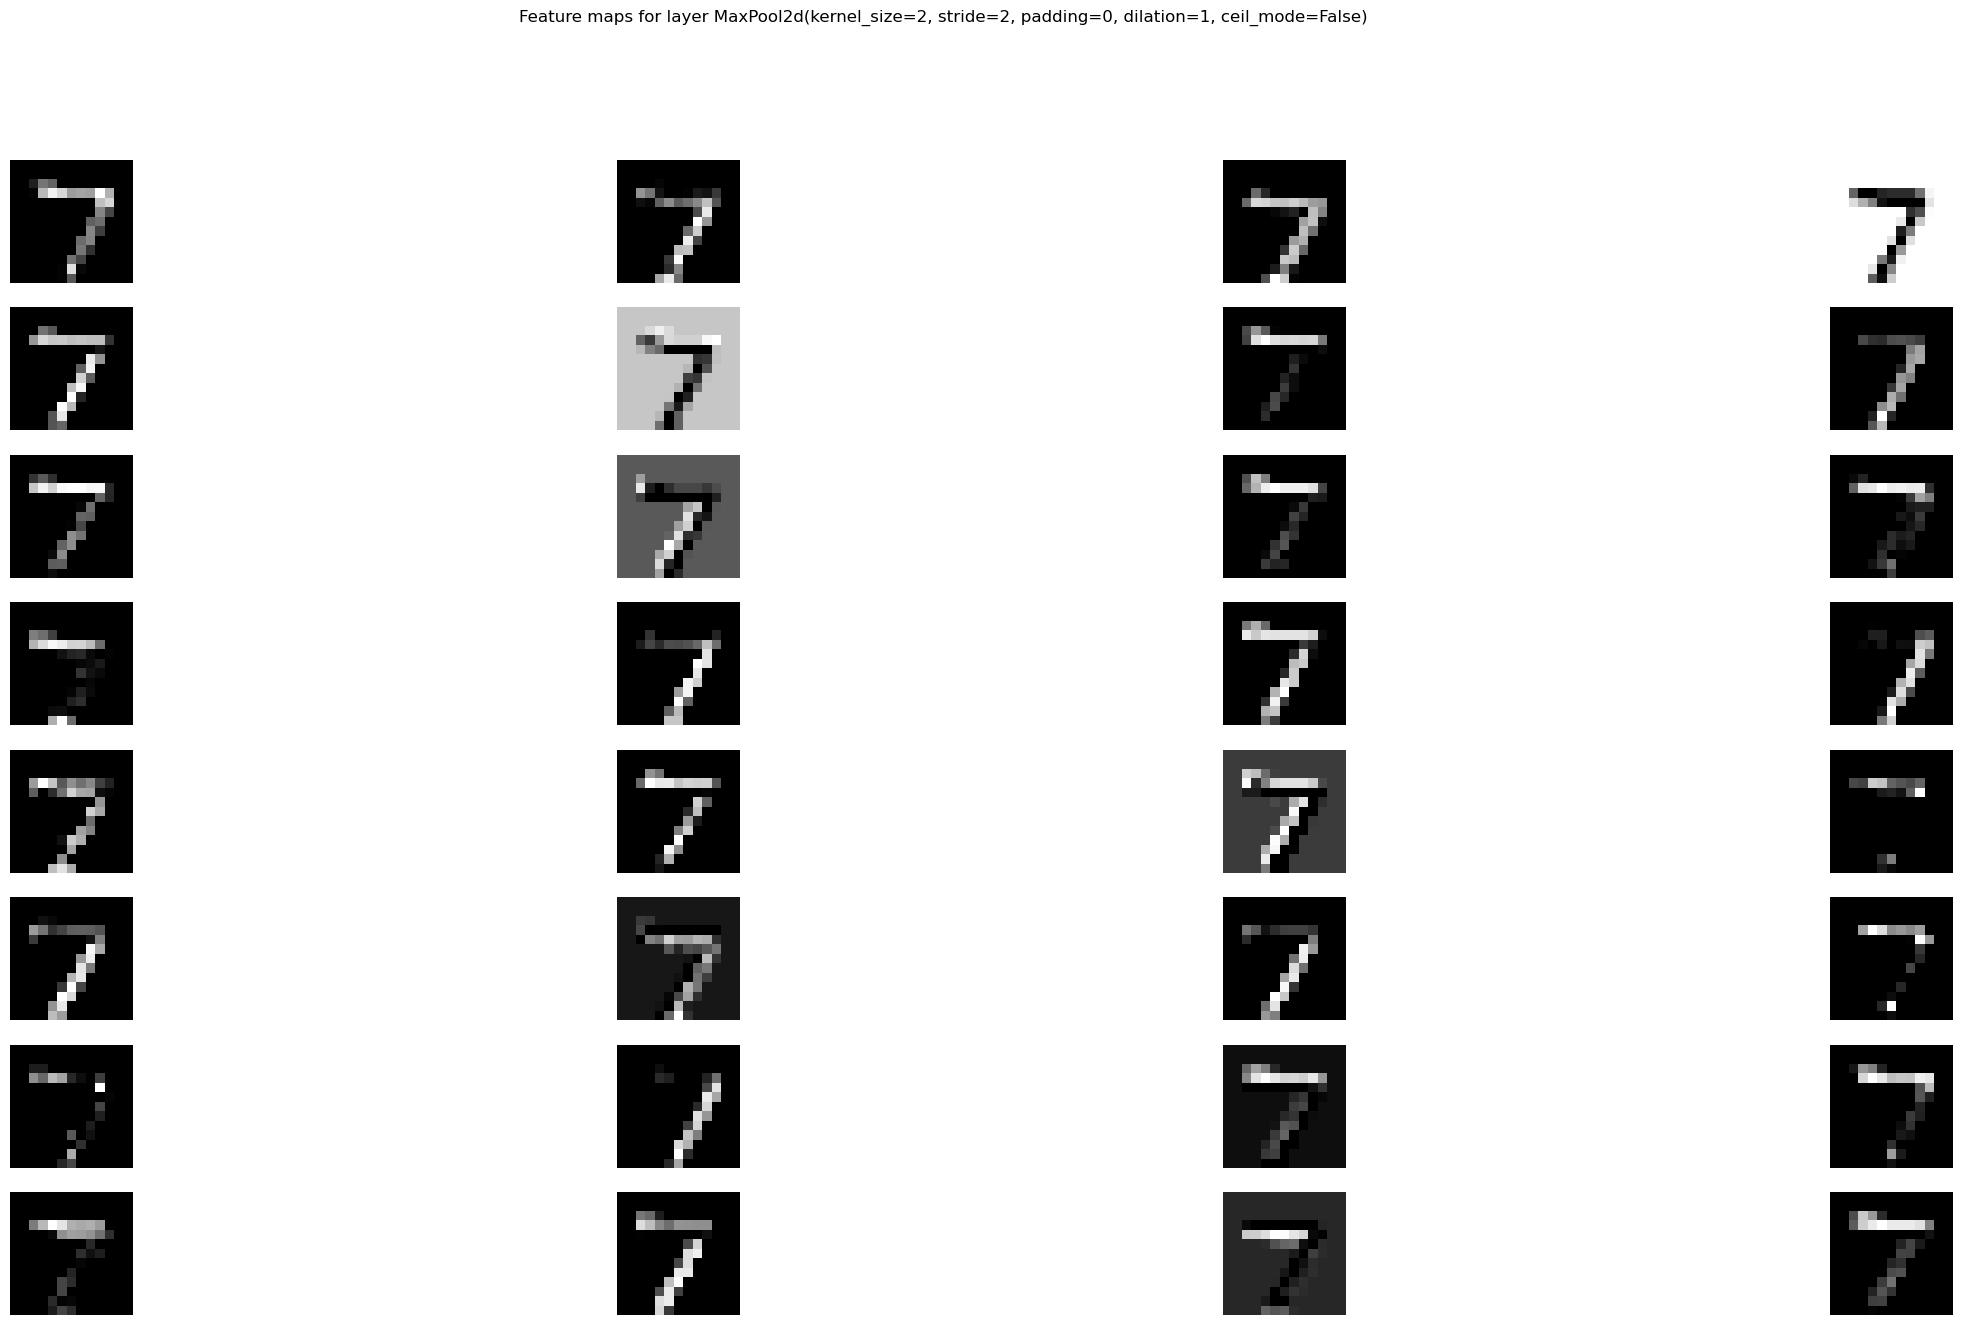

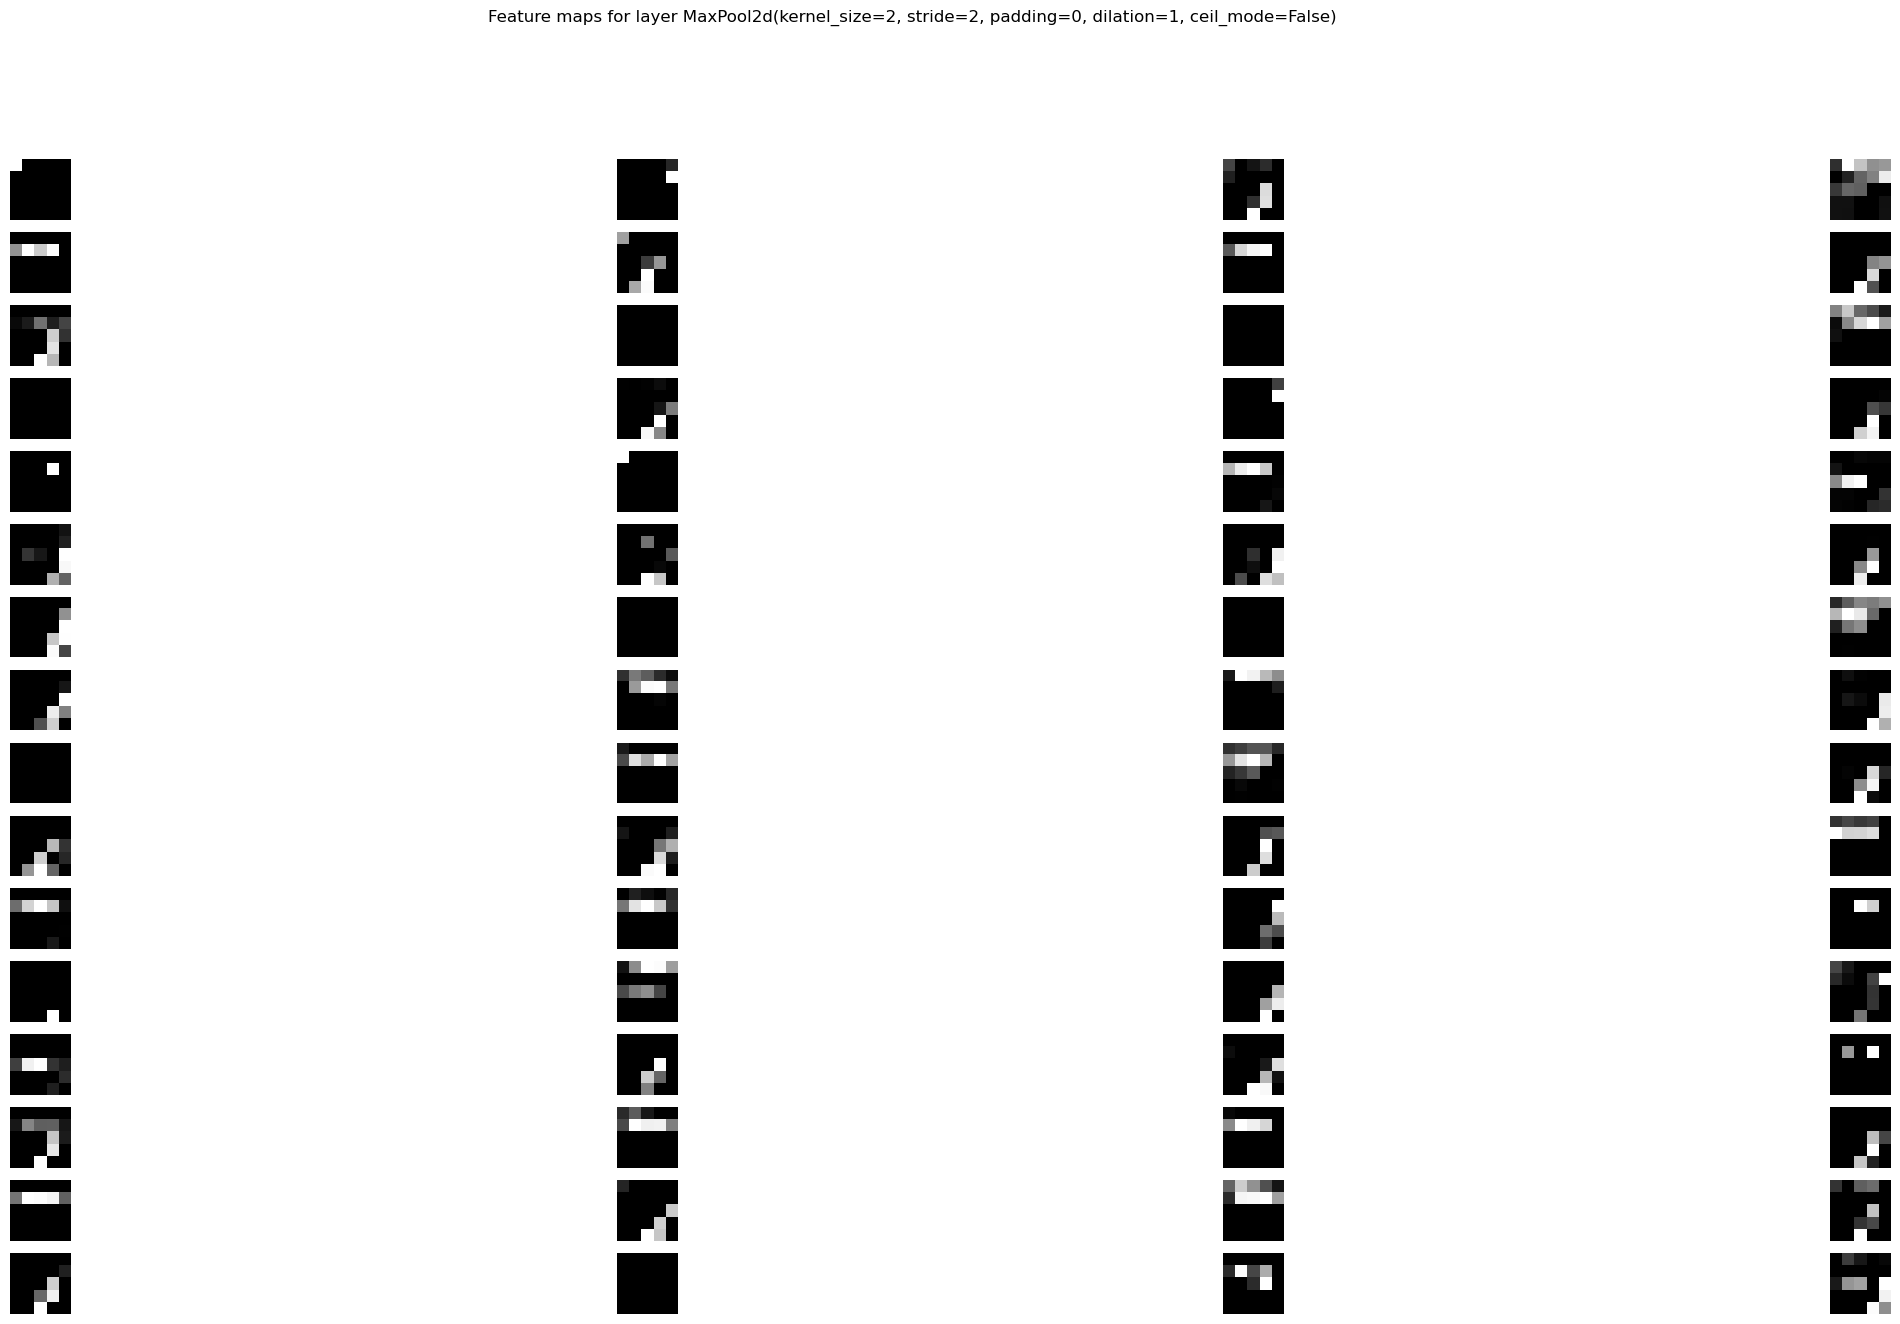

In [84]:
# Displaying feature maps using the function
visualise_feature_map(cnn_baseline, images[0], cnn_baseline.pool)

### Analysis of feature maps
TODO

### 4.3 Hyperparameter Tuning and Evaluation

We tune the CNN using several hyperparameters for the CNN and log results in wandb.

In [9]:
# Sweep Configuration
sweep_cfg = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [2,3,4]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'lr': {
            'values': [0.001, 0.01, 0.1]
        },
        'dropout': {
            'values': [0.25, 0.5, 0.75]
        },
        'kernel_size': {
            'values': [3, 5, 7]
        },
        'stride': {
            'values': [1, 2]
        },
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_cfg, project='assignment-3')

Create sweep with ID: jlunjx0j
Sweep URL: https://wandb.ai/arnav-team/assignment-3/sweeps/jlunjx0j


In [11]:
def sweep_cnn_driver():
    wandb.init(group='MNIST-hyperparams-tuning')
    config = wandb.config
    print('Parameters:')
    print('kernel_size: ', config.kernel_size)
    print('stride: ', config.stride)
    print('dropout: ', config.dropout)
    cnn = CNN(config.kernel_size, config.stride, config.dropout)
    optimizer_ = optim.Adam(cnn.parameters(), lr=config.lr)
    criterion_ = nn.CrossEntropyLoss()
    test_loader_ = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    train_loader_ = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_model_with_logging(cnn, optimizer_, criterion_, train_loader_, epochs=config.epochs,
                             test_data_loader=test_loader_)
    wandb.finish()
    return cnn

In [12]:
wandb.agent(sweep_id, sweep_cnn_driver, count=8)

Parameters:
kernel_size:  3
stride:  2
dropout:  0.75


Training: 100%|██████████| 469/469 [00:19<00:00, 28.77it/s, epoch=1, loss=1.14]

Epoch: 1
Val set: Average loss: 0.0094, Accuracy: 9372/10000 (94%)


Training: 938it [00:43, 25.25it/s, epoch=2, loss=0.855]                         

Epoch: 2
Val set: Average loss: 0.0091, Accuracy: 9335/10000 (93%)


Training: 938it [00:46, 19.98it/s, epoch=2, loss=0.855]

Finished Training


Parameters:
kernel_size:  5
stride:  2
dropout:  0.25


Training: 100%|██████████| 938/938 [00:20<00:00, 49.54it/s, epoch=1, loss=0.338]

Epoch: 1
Val set: Average loss: 0.0035, Accuracy: 9647/10000 (96%)


Training: 1876it [00:47, 48.98it/s, epoch=2, loss=0.234]                        

Epoch: 2
Val set: Average loss: 0.0038, Accuracy: 9660/10000 (97%)


Training: 2814it [01:11, 45.29it/s, epoch=3, loss=0.228]

Epoch: 3
Val set: Average loss: 0.0029, Accuracy: 9737/10000 (97%)


Training: 2814it [01:14, 37.86it/s, epoch=3, loss=0.228]

Finished Training


Parameters:
kernel_size:  7
stride:  2
dropout:  0.5


Training: 100%|██████████| 938/938 [00:28<00:00, 34.93it/s, epoch=1, loss=0.826]

Epoch: 1
Val set: Average loss: 0.0085, Accuracy: 9380/10000 (94%)


Training: 1876it [01:02, 41.77it/s, epoch=2, loss=0.63]                         

Epoch: 2
Val set: Average loss: 0.0073, Accuracy: 9466/10000 (95%)


Training: 1876it [01:05, 28.78it/s, epoch=2, loss=0.63]

Finished Training


Parameters:
kernel_size:  7
stride:  1
dropout:  0.75


Training: 100%|██████████| 938/938 [01:20<00:00, 10.78it/s, epoch=1, loss=0.402]

Epoch: 1
Val set: Average loss: 0.0019, Accuracy: 9797/10000 (98%)


Training: 1876it [02:46, 12.81it/s, epoch=2, loss=0.193]                        

Epoch: 2
Val set: Average loss: 0.0013, Accuracy: 9877/10000 (99%)


Training: 2814it [04:05, 12.96it/s, epoch=3, loss=0.16]  

Epoch: 3
Val set: Average loss: 0.0010, Accuracy: 9895/10000 (99%)


Training: 3752it [05:33, 12.80it/s, epoch=4, loss=0.139]

Epoch: 4
Val set: Average loss: 0.0009, Accuracy: 9917/10000 (99%)


Training: 3752it [05:38, 11.07it/s, epoch=4, loss=0.139]

Finished Training


Parameters:
kernel_size:  3
stride:  1
dropout:  0.25


Training: 100%|██████████| 938/938 [01:12<00:00, 12.97it/s, epoch=1, loss=0.156]

Epoch: 1
Val set: Average loss: 0.0014, Accuracy: 9841/10000 (98%)


Training: 1876it [02:29, 12.59it/s, epoch=2, loss=0.0553]                        

Epoch: 2
Val set: Average loss: 0.0011, Accuracy: 9884/10000 (99%)


Training: 2814it [03:56, 12.43it/s, epoch=3, loss=0.0418] 

Epoch: 3
Val set: Average loss: 0.0010, Accuracy: 9895/10000 (99%)


Training: 3752it [05:18, 13.64it/s, epoch=4, loss=0.0293]

Epoch: 4
Val set: Average loss: 0.0011, Accuracy: 9898/10000 (99%)


Training: 3752it [05:24, 11.57it/s, epoch=4, loss=0.0293]

Finished Training


Parameters:
kernel_size:  7
stride:  2
dropout:  0.75


Training: 100%|██████████| 1875/1875 [00:26<00:00, 70.96it/s, epoch=1, loss=1.57]

Epoch: 1
Val set: Average loss: 0.0182, Accuracy: 9261/10000 (93%)


Training: 3750it [00:55, 73.46it/s, epoch=2, loss=1.21]                          

Epoch: 2
Val set: Average loss: 0.0144, Accuracy: 9457/10000 (95%)


Training: 5625it [01:24, 71.51it/s, epoch=3, loss=1.13]

Epoch: 3
Val set: Average loss: 0.0134, Accuracy: 9502/10000 (95%)


Training: 5625it [01:26, 64.97it/s, epoch=3, loss=1.13]

Finished Training


Parameters:
kernel_size:  7
stride:  2
dropout:  0.75


Training: 100%|██████████| 1875/1875 [00:25<00:00, 75.02it/s, epoch=1, loss=1.44]

Epoch: 1
Val set: Average loss: 0.0150, Accuracy: 9343/10000 (93%)


Training: 3750it [00:54, 71.20it/s, epoch=2, loss=1.12]                           

Epoch: 2
Val set: Average loss: 0.0111, Accuracy: 9435/10000 (94%)


Training: 5625it [01:22, 70.91it/s, epoch=3, loss=1.01] 

Epoch: 3
Val set: Average loss: 0.0092, Accuracy: 9490/10000 (95%)


Training: 7500it [01:50, 75.33it/s, epoch=4, loss=0.946]

Epoch: 4
Val set: Average loss: 0.0087, Accuracy: 9521/10000 (95%)


Training: 7500it [01:52, 66.67it/s, epoch=4, loss=0.946]

Finished Training


Parameters:
kernel_size:  5
stride:  2
dropout:  0.75


Training: 100%|██████████| 1875/1875 [00:25<00:00, 72.78it/s, epoch=1, loss=2.57]

Epoch: 1
Val set: Average loss: 0.0722, Accuracy: 1135/10000 (11%)


Training: 3750it [00:53, 75.65it/s, epoch=2, loss=2.31]                          

Epoch: 2
Val set: Average loss: 0.0726, Accuracy: 1009/10000 (10%)


Training: 5625it [01:21, 64.97it/s, epoch=3, loss=2.31]

Epoch: 3
Val set: Average loss: 0.0724, Accuracy: 1032/10000 (10%)


Training: 5625it [01:24, 66.67it/s, epoch=3, loss=2.31]

Finished Training


## Comparison between dropout and no dropout

We set dropout to 0.25 and then to 0 (no dropout) and compare the results.

In [11]:
cnn_dropout = CNN(3, 1, 0.25)
optimizer = optim.Adam(cnn_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [139]:
train_model_with_logging(cnn_dropout, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

Epoch: 1
Val set: Average loss: 0.0018, Accuracy: 9815/10000 (98%)
Epoch: 2
Val set: Average loss: 0.0012, Accuracy: 9866/10000 (99%)
Epoch: 3
Val set: Average loss: 0.0011, Accuracy: 9880/10000 (99%)
Epoch: 4
Val set: Average loss: 0.0010, Accuracy: 9910/10000 (99%)
Epoch: 5
Val set: Average loss: 0.0011, Accuracy: 9899/10000 (99%)

Finished Training


In [140]:
cnn_no_dropout = CNN(3, 1, 0)
optimizer = optim.Adam(cnn_no_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [141]:
train_model_with_logging(cnn_no_dropout, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

Epoch: 1
Val set: Average loss: 0.0014, Accuracy: 9851/10000 (99%)
Epoch: 2
Val set: Average loss: 0.0013, Accuracy: 9870/10000 (99%)
Epoch: 3
Val set: Average loss: 0.0012, Accuracy: 9882/10000 (99%)
Epoch: 4
Val set: Average loss: 0.0013, Accuracy: 9885/10000 (99%)
Epoch: 5
Val set: Average loss: 0.0012, Accuracy: 9896/10000 (99%)

Finished Training


## 4.4 Model Evaluation and Analysis

We find that the best model has the following hyperparameters:
- kernel_size: 3
- stride: 2
- dropout: 0.25

Now we evaluate the model on the test set and report the confusion matrix and class specific metrics.

In [9]:
cnn_best = CNN(3, 1, 0.25)
optimizer = optim.Adam(cnn_best.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
# Training the best model for 5 epochs
train_model_with_logging(cnn_best, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

Epoch: 1
Val set: Average loss: 0.0013, Accuracy: 9860/10000 (99%)

Finished Training


In [11]:
# copy the test data and reshape it
predicted_labels = test_model(cnn_best, test_dataset)
true_labels = test_dataset.targets.numpy()

In [12]:
# reporting metrics
print('Accuracy: {:.2f}'.format(100. * np.sum(predicted_labels == true_labels) / len(true_labels)))

# per class accuracy
for cls in range(10):
    print('Class {}: {:.2f}'.format(cls,
                                    100. * np.sum((predicted_labels == true_labels) &
                                                  (true_labels == cls)) / np.sum(true_labels == cls)))

Accuracy: 98.60
Class 0: 99.49
Class 1: 98.77
Class 2: 99.13
Class 3: 98.81
Class 4: 98.98
Class 5: 98.65
Class 6: 98.33
Class 7: 99.12
Class 8: 97.54
Class 9: 97.13


In [13]:
# Classification report
print('Classification report:')
print(classification_report(true_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


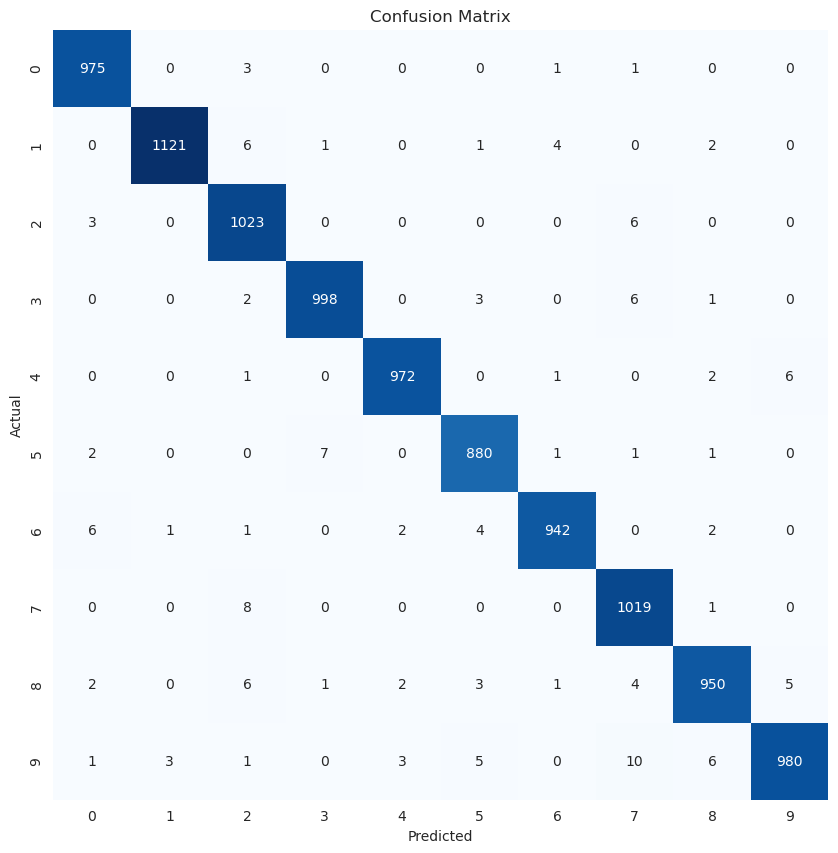

In [14]:
# Visualising the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

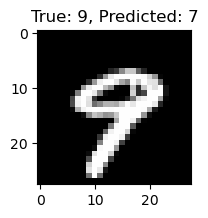

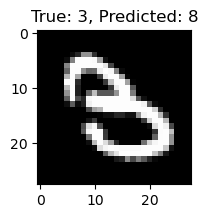

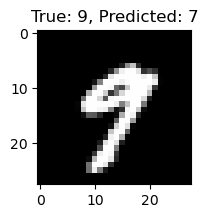

In [157]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]

for i in range(min(3, len(misclassified_indices))):  # Display up to 5 misclassified examples
    index = misclassified_indices[i]
    predicted_class = predicted_labels[index]
    true_class = true_labels[index]

    # Display the misclassified example along with its true and predicted class
    plt.figure(figsize=(2, 2))
    plt.imshow(test_dataset.data[index].reshape(28, 28), cmap="gray")
    plt.title(f"True: {true_class}, Predicted: {predicted_class}")
    plt.show()

### Explanation of error
two of the examples are slanted 9s which the model mistook for similar looking number 7.

The third example is a 3 which is rounded and hence looks like an 8.

## 4.5 Train on Noisy Dataset

We use the noisy mnist dataset with AWGN (Additive White Gaussian Noise) to train the CNN.

In [13]:
# Load the noisy MNIST dataset
data = sio.loadmat('../data/mnist-with-awgn.mat')

train_X_noisy = data['train_x']
test_X_noisy = data['test_x']
train_y_noisy = data['train_y']
test_y_noisy = data['test_y']
letsgo = data['test_y']
# reshape to 28x28
train_X_noisy = train_X_noisy.reshape(-1, 28, 28)
test_X_noisy = test_X_noisy.reshape(-1, 28, 28)

# normalize
train_X_noisy = train_X_noisy / 255.0
test_X_noisy = test_X_noisy / 255.0

train_X_noisy = torch.tensor(train_X_noisy, dtype=torch.float32).reshape(-1, 1, 28, 28)
test_X_noisy = torch.tensor(test_X_noisy, dtype=torch.float32).reshape(-1, 1, 28, 28)
train_y_noisy = torch.argmax(torch.tensor(train_y_noisy, dtype=torch.long), dim=1)
test_y_noisy = torch.argmax(torch.tensor(test_y_noisy, dtype=torch.long), dim=1)

train_dataset = torch.utils.data.TensorDataset(train_X_noisy, train_y_noisy)
test_dataset = torch.utils.data.TensorDataset(test_X_noisy, test_y_noisy)

In [14]:
train_X_noisy.shape, test_X_noisy.shape, train_y_noisy.shape, test_y_noisy.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [15]:
train_noisy_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_noisy_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

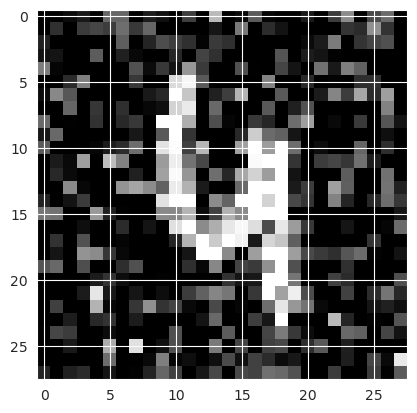

In [16]:
plt.imshow(train_X_noisy[0].reshape(28, 28), cmap='gray')

In [18]:
cnn_best = CNN(3, 1, 0.25)
optimizer = optim.Adam(cnn_best.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
# Training the best model for noised dataset for 10 epochs
train_model_with_logging(cnn_best, optimizer, criterion, train_noisy_loader, epochs=5,
                         test_data_loader=test_noisy_loader)

Training: 1879it [01:26,  2.54it/s, epoch=2, loss=0.12]                            

Epoch: 1
Val set: Average loss: 0.0057, Accuracy: 9484/10000 (95%)


Training: 3752it [03:09,  1.26it/s, epoch=3, loss=0.0228]

Epoch: 2
Val set: Average loss: 0.0028, Accuracy: 9710/10000 (97%)


Training: 5628it [04:49,  1.90it/s, epoch=4, loss=0.0874]

Epoch: 3
Val set: Average loss: 0.0034, Accuracy: 9691/10000 (97%)


Training: 7503it [06:26,  1.88it/s, epoch=5, loss=0.0239]

Epoch: 4
Val set: Average loss: 0.0031, Accuracy: 9765/10000 (98%)


Training: 9375it [07:55, 19.71it/s, epoch=5, loss=0.0491]

Epoch: 5
Val set: Average loss: 0.0035, Accuracy: 9757/10000 (98%)

Finished Training


In [20]:
# evaluate on test set and report metrics
predicted_labels = test_model(cnn_best, test_dataset)
true_labels = test_y_noisy.numpy()

In [21]:
# printing classification report
print('Classification report:')
print(classification_report(true_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


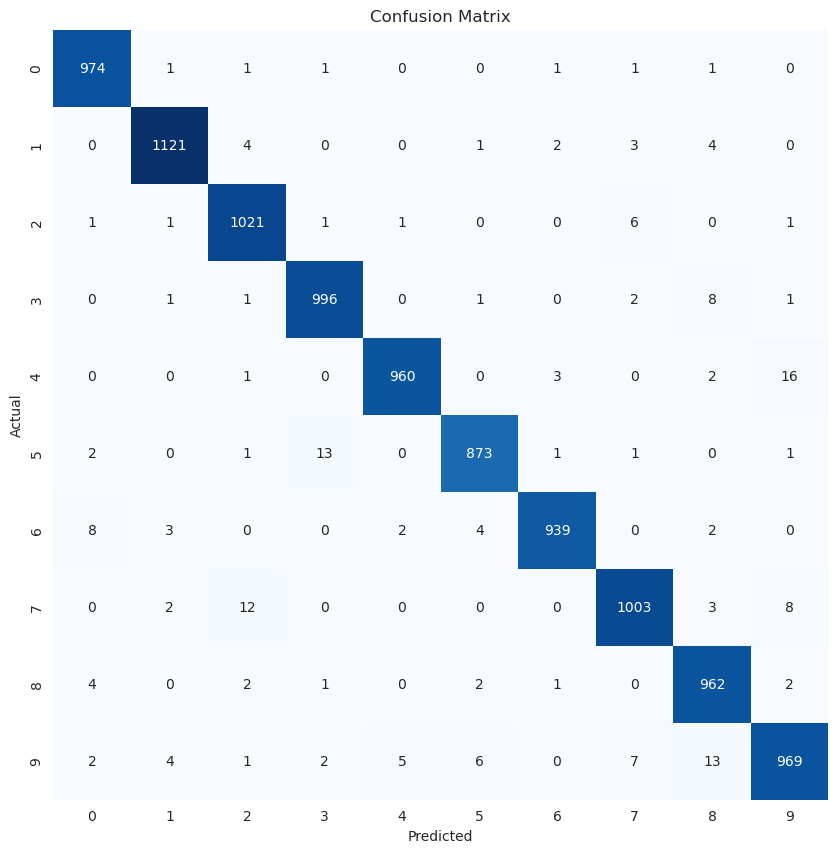

In [22]:
# Visualising the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 4.6 Autoencoders for Denoising

We use an autoencoder to denoise the images and then train the CNN on the denoised images.

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
 # Training the autoencoder
autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [25]:
def train_autoencoder(model, data, optimizer, loss_fn, epochs=5):
    progress_bar = tqdm(total=len(data), desc='Training')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(data):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images.reshape(-1, 28 * 28))
            loss = loss_fn(outputs, images.reshape(-1, 28 * 28))
            running_loss += loss.item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=running_loss / (i + 1), epoch=epoch + 1)
            progress_bar.update()

        progress_bar.refresh()
        running_loss /= len(data)
        print('Epoch:', epoch + 1)
        print('Train set: Average loss: {:.4f}\n'.format(running_loss))
    print('Finished Training')

In [13]:
train_autoencoder(autoencoder, train_noisy_loader, optimizer, criterion, epochs=4)

Training: 1880it [00:58, 34.98it/s, epoch=2, loss=0.0512]                          

Epoch: 1
Train set: Average loss: 0.0598


Training: 3755it [01:55, 31.83it/s, epoch=3, loss=0.0488]

Epoch: 2
Train set: Average loss: 0.0498


Training: 5630it [02:53, 33.52it/s, epoch=4, loss=0.0469]

Epoch: 3
Train set: Average loss: 0.0476


Training: 7500it [03:48, 32.78it/s, epoch=4, loss=0.0466]

Epoch: 4
Train set: Average loss: 0.0466

Finished Training


In [15]:
# Getting the denoised images
denoised_images = autoencoder(test_X_noisy.reshape(-1, 784)).detach().numpy()

In [16]:
# Visualising the denoised images for each class
def visualise_samples(data, labels):
    fig, ax = plt.subplots(1, 10, figsize=(20, 10))
    for i in range(10):
        idx = np.where(labels == i)[0][:1]
        ax[i].set_title(labels[idx[0]])
        ax[i].imshow(data[idx[0]].reshape(28, 28), cmap='gray')
        ax[i].axis('off')

Original images:
Denoised images:


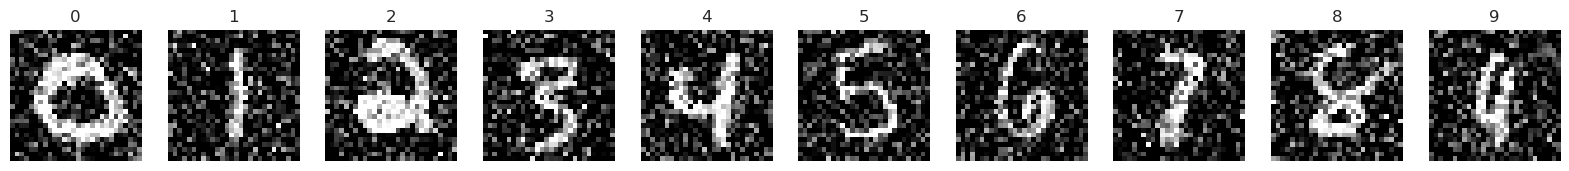

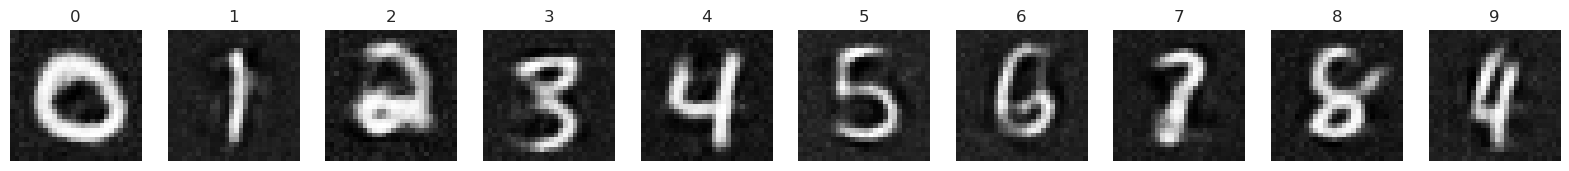

In [17]:
print('Original images:')
visualise_samples(test_X_noisy, test_y_noisy.numpy())
print('Denoised images:')
visualise_samples(denoised_images, test_y_noisy.numpy())

In [72]:
# Visualising feature space using t-SNE before and after denoising
from sklearn.manifold import TSNE

In [73]:
tsne_noisy = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(test_X_noisy.reshape(-1, 28 * 28))
tsne_denoised = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(denoised_images)

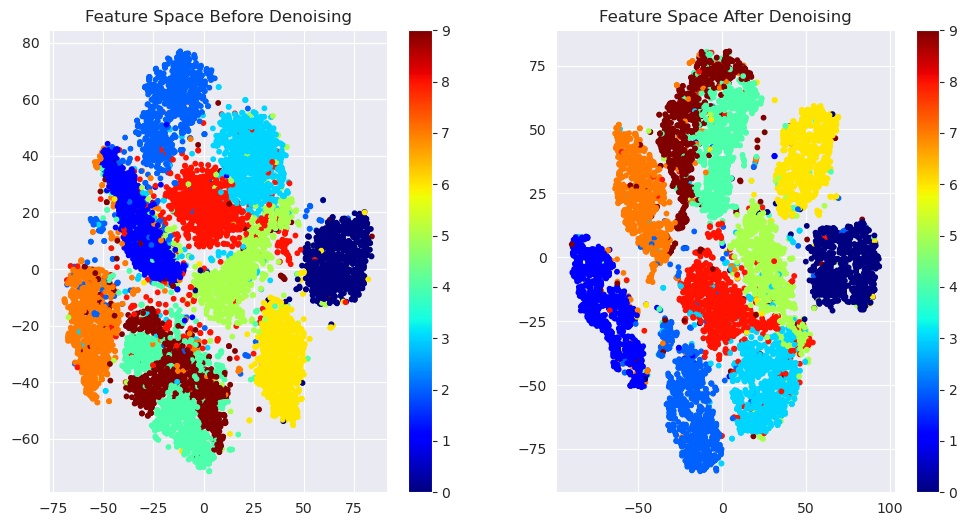

In [74]:
# Step 4: Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(tsne_noisy[:, 0], tsne_noisy[:, 1], c=test_y_noisy, cmap=plt.get_cmap('jet'), s=10)
plt.title('Feature Space Before Denoising')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(tsne_denoised[:, 0], tsne_denoised[:, 1], c=test_y_noisy, cmap=plt.get_cmap('jet'), s=10)
plt.title('Feature Space After Denoising')
plt.colorbar()

In [20]:
# Train cnn on denoised dataset
cnn_best = CNN(3, 1, 0.25)
optimizer = optim.Adam(cnn_best.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
train_denoised_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(denoised_images.reshape(-1, 1, 28, 28), dtype=torch.float32),
                                   test_y_noisy), batch_size=32, shuffle=True)
test_denoised_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(denoised_images.reshape(-1, 1, 28, 28), dtype=torch.float32),
                                   test_y_noisy), batch_size=32, shuffle=False)

In [22]:
# Training the best model for denoised dataset for 5 epochs
train_model_with_logging(cnn_best, optimizer, criterion, train_denoised_loader, epochs=10,
                         test_data_loader=test_denoised_loader)

Training: 316it [00:21,  1.58it/s, epoch=2, loss=0.292]                         

Epoch: 1
Val set: Average loss: 0.0107, Accuracy: 8982/10000 (90%)


Training: 629it [00:45,  1.70it/s, epoch=3, loss=0.2]  

Epoch: 2
Val set: Average loss: 0.0061, Accuracy: 9434/10000 (94%)


Training: 943it [01:08,  1.90it/s, epoch=4, loss=0.136]

Epoch: 3
Val set: Average loss: 0.0092, Accuracy: 9260/10000 (93%)


Training: 1255it [01:40,  1.25it/s, epoch=5, loss=0.0633]

Epoch: 4
Val set: Average loss: 0.0087, Accuracy: 9374/10000 (94%)


Training: 1568it [02:02,  1.88it/s, epoch=6, loss=0.0753]

Epoch: 5
Val set: Average loss: 0.0048, Accuracy: 9627/10000 (96%)


Training: 1882it [02:23,  2.21it/s, epoch=7, loss=0.0562]

Epoch: 6
Val set: Average loss: 0.0044, Accuracy: 9671/10000 (97%)


Training: 2194it [02:44,  2.38it/s, epoch=8, loss=0.0601]

Epoch: 7
Val set: Average loss: 0.0040, Accuracy: 9709/10000 (97%)


Training: 2507it [03:05,  1.91it/s, epoch=9, loss=0.077] 

Epoch: 8
Val set: Average loss: 0.0038, Accuracy: 9712/10000 (97%)


Training: 2820it [03:26,  2.21it/s, epoch=10, loss=0.0246]

Epoch: 9
Val set: Average loss: 0.0056, Accuracy: 9642/10000 (96%)


Training: 3130it [03:46, 13.81it/s, epoch=10, loss=0.0623]

Epoch: 10
Val set: Average loss: 0.0040, Accuracy: 9763/10000 (98%)

Finished Training


In [27]:
# Evaluating the model on the test set and reporting metrics
predicted_labels = test_model(cnn_best, test_denoised_loader.dataset)
true_labels = test_y_noisy.numpy()

In [28]:
# printing classification report
print('Classification report:')
print(classification_report(true_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


### Compare results with noisy dataset and denoised dataset

TODO

# 5. Some Other Variants

The DoubleMNIST dataset contains images with two handwritten digits, and the task is to correctly identify and classify each digit within the image.

We build models that will simultaneously classify both digits in the image. This is a multilabel classification problem, since each image can contain multiple classes (digits) at once.

In [30]:
# Need to extract the data by reading the image files.
data_dir = '../data/double_mnist_seed_123_image_size_64_64/'

def read_img_dataset(path):
    imgs = []
    labels = []
    for i in range(10):
        for j in range(10):
            if i == j: 
                continue
            
            if str(i) + str(j) in os.listdir(path):
                print('Reading from : ', i,j)
                cls = str(i) + str(j)
                # read imgs and append
                for img_path in tqdm(os.listdir(path + '/' + cls)):
                    imgs.append(torchvision.io.read_image(path + '/' + cls + '/' + img_path, torchvision.io.ImageReadMode.GRAY).float() / 255.0)
                    labels.append((i, j))
                    
    # One hot encode labels
    n_samples = len(imgs)
    labels_ohe = torch.zeros((n_samples, 10))
    for i in range(n_samples):
        labels_ohe[labels[i][0]] = 1
        labels_ohe[labels[i][1]] = 1
    
    return torch.utils.data.TensorDataset(torch.stack(imgs), labels_ohe)

In [31]:
test_loader = torch.utils.data.DataLoader(read_img_dataset(data_dir + 'test'), batch_size = 32, shuffle = False )
train_loader = torch.utils.data.DataLoader(read_img_dataset(data_dir + 'train'), batch_size = 32, shuffle = True )
val_loader = torch.utils.data.DataLoader(read_img_dataset(data_dir + 'val'), batch_size = 32, shuffle = False)

Reading from :  0 2


100%|██████████| 1000/1000 [00:16<00:00, 60.21it/s]


Reading from :  1 7


 89%|████████▉ | 893/1000 [00:15<00:01, 56.49it/s]


KeyboardInterrupt: 

In [50]:
# Plot some images
def plot_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.numpy().transpose(1, 2, 0))
        axes[i].set_title(label.numpy())
        axes[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


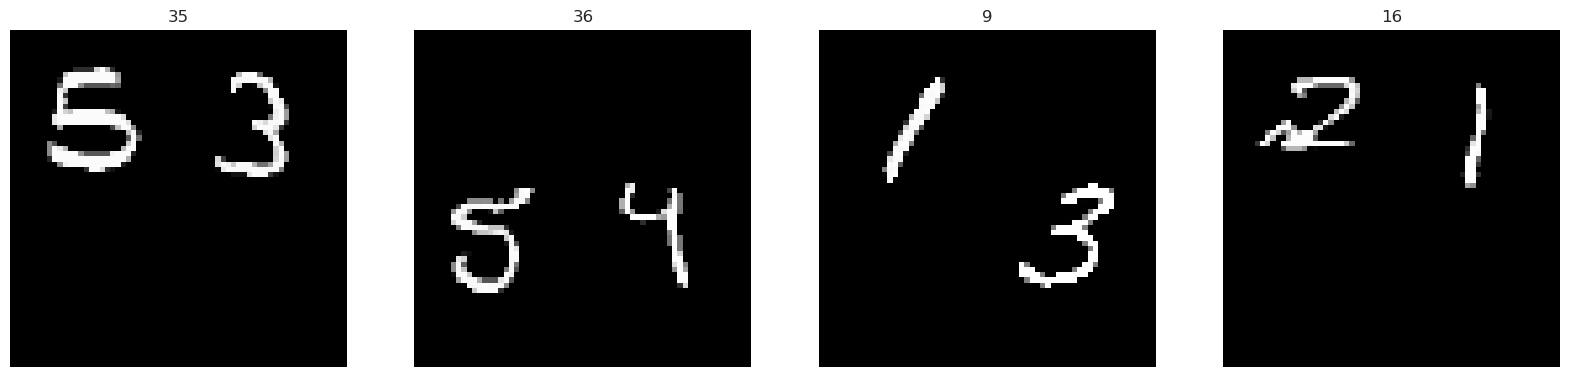

In [51]:
plot_images(*next(iter(train_loader)))

## 5.1.1 MLP on Multi-MNIST

In [9]:
# Model architecture
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        layers.append(nn.Sigmoid())
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)
    
    def predict(self, activations):
        top_indices = np.argsort(activations, axis=1)[:, -2:]
        one_hot_encoded = np.zeros_like(activations)
        one_hot_encoded[np.arange(one_hot_encoded.shape[0])[:, None], top_indices] = 1
        return one_hot_encoded

In [8]:
model = MLPModel(64*64, [512, 128, 64], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# function to train a model:
def train_multi_with_logging(model, optimizer, loss_fn, train_data_loader, test_data_loader=None, epochs=10):
    progress_bar = tqdm(total=len(train_data_loader), desc='Training')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for i, (images, labels) in enumerate(train_data_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            one_hot_encoded = model.predict(outputs.detach().numpy())
            
            train_accuracy += torch.tensor((one_hot_encoded == labels), dtype=torch.float32).mean(dim=1).sum().item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=running_loss / (i + 1), epoch=epoch + 1)
            progress_bar.update()

        progress_bar.refresh()
        train_accuracy /= len(train_data_loader.dataset)
        running_loss /= len(train_data_loader)

        if test_data_loader is None:
            continue

        model.eval()
        test_loss = 0
        correct = 0
        # running predictions for confusion matrix
        running_preds = []
        running_true = []
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += loss_fn(output, target).item()  # sum up batch loss
                pred = model.predict(output.numpy())
                
                running_preds.extend(list(pred.numpy().squeeze()))
                running_true.extend(list(target.numpy().squeeze()))
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('Epoch:', epoch + 1)
        print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct,
                                                                                  len(test_loader.dataset),
                                                                                  100. * correct / len(
                                                                                      test_loader.dataset)))

        # Log training/validation loss and accuracy, confusion matrices, and class specific metrics using W&B
        if wandb.run is not None:
            wandb.log({
                'val_loss': test_loss,
                'val_accuracy': 100. * correct / len(test_loader.dataset),
                'train_loss': running_loss,
                'train_accuracy': train_accuracy,
                'confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                y_true=running_true,
                                                                preds=running_preds,
                                                                class_names=np.arange(10)),
                'f1': f1_score(running_true, running_preds, average='macro', zero_division=0),
                'precision': precision_score(running_true, running_preds, average='macro', zero_division=0),
                'recall': recall_score(running_true, running_preds, average='macro', zero_division=0)
            }, step=epoch + 1)

    print('Finished Training')

In [13]:
def test_multi_model(model, data_loader):
    # Set model to evaluation mode
    model.eval()
    # Create empty list to store predictions
    predictions = []
    # Iterate over test batches
    for batch in data_loader:
        # Extract images and labels
        images, labels = batch
        # Forward pass
        outputs = model(images)
        outputs = model.predict(outputs.detach().numpy())
        # Append predictions from output
        predictions.extend(outputs.argmax(dim=1).numpy())
    return np.array(predictions)

In [11]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'num_layers': {
            'values': [1, 2, 3]
        },
        'hidden_size': {
            'values': [32, 64, 128, 256]
        },
    },
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project='assignment-3')

Create sweep with ID: 2mpa1gek
Sweep URL: https://wandb.ai/arnav-team/assignment-3/sweeps/2mpa1gek


In [ ]:
def mlp_sweep():
    wandb.init(group='DoubleMNIST-MLP-hyperparams')
    config = wandb.config
    print('Parameters:')
    print('num_layers: ', config.num_layers)
    print('hidden_size: ', config.hidden_size)
    model = MLPModel(64*64, [config.hidden_size]*config.num_layers, 10)
    optimizer_ = optim.Adam(model.parameters(), lr=0.001)
    criterion_ = nn.CrossEntropyLoss()
    train_multi_with_logging(model, optimizer_, criterion_, train_loader, epochs=5,
                             test_data_loader=val_loader)
    wandb.finish()
    return model

In [ ]:
wandb.agent(sweep_id, train_multi_with_logging, args=[model, optimizer, criterion, train_loader, val_loader])

In [ ]:
## Evaluate model
predicted_labels = test_model(model, test_loader.dataset)
print('Accuracy: {:.2f}'.format(100. *(1-hamming_loss(predicted_labels, test_loader.dataset[1])) / len(test_loader.dataset)))
print('Recall: {:.2f}'.format(100. * recall_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('Precision: {:.2f}'.format(100. * precision_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('F1: {:.2f}'.format(100. * f1_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))

## 5.1.2 CNN on Multi-MNIST

In [20]:
class CNN_multi(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dropout=0.25, input_size=64):
        super(CNN_multi, self).__init__()
        self.nn_layers = nn.ModuleList()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride)
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        # Calculate number of features after convolutions
        l = input_size
        l = (l - kernel_size) // stride + 1
        l = (l - kernel_size) // stride + 1
        l = (l - 2) // 2 + 1
        self.fc1 = nn.Linear(64 * l * l, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def predict(self, activations):
        top_indices = np.argsort(activations, axis=1)[:, -2:]
        one_hot_encoded = np.zeros_like(activations)
        one_hot_encoded[np.arange(one_hot_encoded.shape[0])[:, None], top_indices] = 1
        return one_hot_encoded

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': [0.001, 0.01],
        'kernel_sizes': [3, 5],
        'dropout': [0.25, 0.5, 0.75],
    },
}
sweep_id = wandb.sweep(sweep_config, project='assignment-3')

In [ ]:
def cnn_sweep():
    wandb.init(group='DoubleMNIST-CNN-hyperparams')
    config = wandb.config
    print('Parameters:')
    print('lr: ', config.lr)
    print('kernel_sizes: ', config.kernel_sizes)
    print('dropout: ', config.dropout)
    model = CNN_multi(config.kernel_sizes, 1, config.dropout)
    optimizer_ = optim.Adam(model.parameters(), lr=config.lr)
    criterion_ = nn.CrossEntropyLoss()
    train_multi_with_logging(model, optimizer_, criterion_, train_loader, epochs=5,
                             test_data_loader=val_loader)
    wandb.finish()
    return model

In [ ]:
wandb.agent(sweep_id, train_multi_with_logging, args=[model, optimizer, criterion, train_loader, val_loader])

In [ ]:
## Evaluate model
predicted_labels = test_model(model, test_loader.dataset)
print('Accuracy: {:.2f}'.format(100. *(1-hamming_loss(predicted_labels, test_loader.dataset[1])) / len(test_loader.dataset)))
print('Recall: {:.2f}'.format(100. * recall_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('Precision: {:.2f}'.format(100. * precision_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('F1: {:.2f}'.format(100. * f1_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))

## 5.1.3 Testing on Single digit MNIST (regular MNIST)


In [ ]:
# Importing the MNIST dataset
# Tranform to tensor, convert to float and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Resize((64, 64))])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def test_on_single_digit(model, data_loader):
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    # Create empty list to store predictions
    predictions = []
    correct=  0
    count = 0
    # Iterate over test batches
    for batch in tqdm(data_loader):
        # Extract images and labels
        images, labels = batch
        images = images.reshape(len(images), 1, 64, 64)
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        outputs = outputs.argmax(dim=1)
        correct += (outputs == labels).float().sum().item()
        count += len(images)
    correct /= count
    print('Accuracy: ', correct)
    return np.array(predictions)

In [ ]:
test_on_single_digit(model, test_loader)

## 5.2 Permuted MNIST

We run models on the permuted MNIST dataset.

In [27]:
data = np.load('../data/permuted_mnist.npz')

NpzFile '../data/permuted_mnist.npz' with keys: train_images, train_labels, test_images, test_labels

In [28]:
train_images = data['train_images']
train_labels = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [32]:
train_images = torch.tensor(train_images, dtype=torch.float32).reshape(-1, 1, 28, 28)
test_images = torch.tensor(test_images, dtype=torch.float32).reshape(-1, 1, 28, 28)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [33]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_images, train_labels), batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_images, test_labels), batch_size=32, shuffle=False)

## 5.2.1 MLP on Permuted-MNIST

In [34]:
def train_model_with_logging_gpu(model, optimizer, loss_fn, train_data_loader, epochs=10, test_data_loader=None):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for images, labels in tqdm(train_data_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images.cuda())
            loss = loss_fn(outputs, labels.cuda())
            running_loss += loss.item()
            train_accuracy += torch.tensor((outputs.argmax(dim=1) == labels.cuda()), dtype=torch.float32).mean().item()

            # Backward and optimize
            loss.backward()
            optimizer.step()
        train_accuracy /= len(train_data_loader.dataset)
        running_loss /= len(train_data_loader)

        if test_data_loader is None:
            continue

        model.eval()
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data.cuda())
                test_loss += loss_fn(output, target.cuda()).item()  # sum up batch loss
                pred = output.argmax(dim=1).cpu()
                accuracy += pred.eq(target.view_as(pred)).sum().item()
                
        test_loss /= len(test_loader.dataset)
        accuracy /= len(test_loader.dataset)
        print('Epoch:', epoch + 1)
        print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, accuracy,
                                                                                  len(test_loader.dataset),
                                                                                  100. * accuracy))
        # Log training/validation loss and accuracy
        if wandb.run is not None:
            wandb.log({
                'val_loss': test_loss,
                'val_accuracy': 100. * accuracy,
                'train_loss': running_loss,
                'train_accuracy': train_accuracy
            }, step=epoch + 1)

In [37]:
def test_multi_model(model, data_loader):
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    # Create empty list to store predictions
    predictions = []
    correct=  0
    count = 0
# Iterate over test batches
    for batch in data_loader:
        # Extract images and labels
        images, labels = batch
        # Forward pass
        outputs = model(images.cuda())
        outputs = outputs.argmax(dim=1).cpu()
        # Append predictions from output
        predictions.extend(outputs.numpy())
        correct += outputs.eq(labels.view_as(outputs)).sum().item()
        count += len(labels)
    print('Accuracy: ', correct/count)
    return np.array(predictions), correct/count

In [38]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        layers.append(nn.LogSoftmax())
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [41]:
mlp = MLPModel(28*28, [32, 32], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

In [40]:
train_model_with_logging(mlp, optimizer, criterion, train_loader, epochs=4, test_data_loader=test_loader)

Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 1891it [00:27, 24.45it/s, epoch=2, loss=0.111]                          

Epoch: 1
Val set: Average loss: 0.0044, Accuracy: 9607/10000 (96%)


Training: 3769it [00:52, 25.97it/s, epoch=3, loss=0.0829]

Epoch: 2
Val set: Average loss: 0.0036, Accuracy: 9680/10000 (97%)


Training: 5643it [01:13, 35.65it/s, epoch=4, loss=0.0455] 

Epoch: 3
Val set: Average loss: 0.0031, Accuracy: 9720/10000 (97%)


Training: 7500it [01:30, 82.50it/s, epoch=4, loss=0.0933] 

Epoch: 4
Val set: Average loss: 0.0043, Accuracy: 9638/10000 (96%)

Finished Training


In [42]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'num_layers': {
            'values': [1, 2, 3]
        },
        'hidden_size': {
            'values': [32, 64, 128, 256]
        },
    },
}
sweep_id = wandb.sweep(sweep_config, project='assignment-3')

Create sweep with ID: lcsau19e
Sweep URL: https://wandb.ai/arnav-team/assignment-3/sweeps/lcsau19e


In [43]:
def mlp_sweep():
    wandb.init(group='PermutedMNIST-MLP-hyperparams')
    config = wandb.config
    print('Parameters:')
    print('num_layers: ', config.num_layers)
    print('hidden_size: ', config.hidden_size)
    model = MLPModel(28*28, [config.hidden_size]*config.num_layers, 10)
    optimizer_ = optim.Adam(model.parameters(), lr=0.001)
    criterion_ = nn.CrossEntropyLoss()
    train_model_with_logging(model, optimizer_, criterion_, train_loader, epochs=5,
                             test_data_loader=test_loader)
    wandb.finish()
    return model

In [44]:
wandb.agent(sweep_id, mlp_sweep, count=10)

Parameters:
num_layers:  3
hidden_size:  128


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:21<00:00, 35.88it/s, epoch=1, loss=0.264] 

Epoch: 1
Val set: Average loss: 0.0047, Accuracy: 9565/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:39, 122.48it/s, epoch=2, loss=0.147]                         

Epoch: 2
Val set: Average loss: 0.0045, Accuracy: 9589/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:56, 114.20it/s, epoch=3, loss=0.12]  

Epoch: 3
Val set: Average loss: 0.0037, Accuracy: 9687/10000 (97%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [01:14, 122.64it/s, epoch=4, loss=0.104] 

Epoch: 4
Val set: Average loss: 0.0044, Accuracy: 9667/10000 (97%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:30, 123.83it/s, epoch=5, loss=0.097]  

Epoch: 5
Val set: Average loss: 0.0051, Accuracy: 9602/10000 (96%)


Training: 9375it [01:31, 102.00it/s, epoch=5, loss=0.097]

Finished Training


Parameters:
num_layers:  3
hidden_size:  64


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:14<00:00, 143.27it/s, epoch=1, loss=0.301]

Epoch: 1
Val set: Average loss: 0.0050, Accuracy: 9518/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:30, 124.69it/s, epoch=2, loss=0.168]                          

Epoch: 2
Val set: Average loss: 0.0048, Accuracy: 9555/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:46, 90.69it/s, epoch=3, loss=0.138]  

Epoch: 3
Val set: Average loss: 0.0041, Accuracy: 9621/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [01:03, 125.53it/s, epoch=4, loss=0.119] 

Epoch: 4
Val set: Average loss: 0.0047, Accuracy: 9618/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:19, 127.79it/s, epoch=5, loss=0.107] 

Epoch: 5
Val set: Average loss: 0.0043, Accuracy: 9629/10000 (96%)


Training: 9375it [01:20, 117.12it/s, epoch=5, loss=0.107]

Finished Training


Parameters:
num_layers:  1
hidden_size:  32


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:14<00:00, 160.88it/s, epoch=1, loss=0.663]

Epoch: 1
Val set: Average loss: 0.0112, Accuracy: 8975/10000 (90%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:28, 158.68it/s, epoch=2, loss=0.292]                          

Epoch: 2
Val set: Average loss: 0.0086, Accuracy: 9186/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:42, 99.60it/s, epoch=3, loss=0.26]   

Epoch: 3
Val set: Average loss: 0.0084, Accuracy: 9252/10000 (93%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:57, 173.60it/s, epoch=4, loss=0.242]

Epoch: 4
Val set: Average loss: 0.0077, Accuracy: 9393/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:11, 165.39it/s, epoch=5, loss=0.233] 

Epoch: 5
Val set: Average loss: 0.0074, Accuracy: 9417/10000 (94%)


Training: 9375it [01:12, 129.37it/s, epoch=5, loss=0.233]

Finished Training


Parameters:
num_layers:  2
hidden_size:  128


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:16<00:00, 126.97it/s, epoch=1, loss=0.325]

Epoch: 1
Val set: Average loss: 0.0067, Accuracy: 9379/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:32, 120.38it/s, epoch=2, loss=0.168]                          

Epoch: 2
Val set: Average loss: 0.0052, Accuracy: 9542/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:48, 121.78it/s, epoch=3, loss=0.146] 

Epoch: 3
Val set: Average loss: 0.0054, Accuracy: 9501/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [01:05, 135.51it/s, epoch=4, loss=0.134] 

Epoch: 4
Val set: Average loss: 0.0045, Accuracy: 9619/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:21, 126.57it/s, epoch=5, loss=0.12]  

Epoch: 5
Val set: Average loss: 0.0050, Accuracy: 9584/10000 (96%)


Training: 9375it [01:22, 112.98it/s, epoch=5, loss=0.12]

Finished Training


Parameters:
num_layers:  2
hidden_size:  256


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:16<00:00, 126.04it/s, epoch=1, loss=0.32] 

Epoch: 1
Val set: Average loss: 0.0049, Accuracy: 9539/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:32, 115.73it/s, epoch=2, loss=0.159]                           

Epoch: 2
Val set: Average loss: 0.0050, Accuracy: 9536/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:50, 119.15it/s, epoch=3, loss=0.138] 

Epoch: 3
Val set: Average loss: 0.0046, Accuracy: 9620/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [01:09, 91.63it/s, epoch=4, loss=0.128]  

Epoch: 4
Val set: Average loss: 0.0050, Accuracy: 9625/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:28, 111.71it/s, epoch=5, loss=0.112] 

Epoch: 5
Val set: Average loss: 0.0042, Accuracy: 9680/10000 (97%)


Training: 9375it [01:29, 104.81it/s, epoch=5, loss=0.112]

Finished Training


Parameters:
num_layers:  2
hidden_size:  64


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:14<00:00, 113.94it/s, epoch=1, loss=0.352]

Epoch: 1
Val set: Average loss: 0.0059, Accuracy: 9432/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:29, 168.92it/s, epoch=2, loss=0.18]                           

Epoch: 2
Val set: Average loss: 0.0053, Accuracy: 9521/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:43, 140.65it/s, epoch=3, loss=0.152] 

Epoch: 3
Val set: Average loss: 0.0052, Accuracy: 9542/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:57, 153.28it/s, epoch=4, loss=0.132] 

Epoch: 4
Val set: Average loss: 0.0054, Accuracy: 9548/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:11, 109.45it/s, epoch=5, loss=0.128] 

Epoch: 5
Val set: Average loss: 0.0044, Accuracy: 9589/10000 (96%)


Training: 9375it [01:12, 130.06it/s, epoch=5, loss=0.128]

Finished Training


Parameters:
num_layers:  1
hidden_size:  32


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:09<00:00, 230.44it/s, epoch=1, loss=0.666]

Epoch: 1
Val set: Average loss: 0.0116, Accuracy: 8978/10000 (90%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:19, 217.98it/s, epoch=2, loss=0.3]                            

Epoch: 2
Val set: Average loss: 0.0085, Accuracy: 9240/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:28, 241.10it/s, epoch=3, loss=0.27] 

Epoch: 3
Val set: Average loss: 0.0089, Accuracy: 9237/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:37, 198.14it/s, epoch=4, loss=0.258]

Epoch: 4
Val set: Average loss: 0.0089, Accuracy: 9262/10000 (93%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [00:47, 188.74it/s, epoch=5, loss=0.246]

Epoch: 5
Val set: Average loss: 0.0073, Accuracy: 9362/10000 (94%)


Training: 9375it [00:48, 192.91it/s, epoch=5, loss=0.246]

Finished Training


Parameters:
num_layers:  1
hidden_size:  32


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:09<00:00, 235.96it/s, epoch=1, loss=0.683]

Epoch: 1
Val set: Average loss: 0.0119, Accuracy: 8930/10000 (89%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:18, 196.30it/s, epoch=2, loss=0.337]                          

Epoch: 2
Val set: Average loss: 0.0101, Accuracy: 9121/10000 (91%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:27, 212.29it/s, epoch=3, loss=0.307]

Epoch: 3
Val set: Average loss: 0.0097, Accuracy: 9164/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:37, 250.24it/s, epoch=4, loss=0.296]

Epoch: 4
Val set: Average loss: 0.0094, Accuracy: 9221/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [00:46, 245.70it/s, epoch=5, loss=0.287]

Epoch: 5
Val set: Average loss: 0.0097, Accuracy: 9198/10000 (92%)


Training: 9375it [00:47, 198.06it/s, epoch=5, loss=0.287]

Finished Training


Parameters:
num_layers:  1
hidden_size:  128


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:10<00:00, 214.69it/s, epoch=1, loss=0.477]

Epoch: 1
Val set: Average loss: 0.0087, Accuracy: 9235/10000 (92%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:20, 196.98it/s, epoch=2, loss=0.226]                          

Epoch: 2
Val set: Average loss: 0.0068, Accuracy: 9468/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:31, 201.13it/s, epoch=3, loss=0.2]  

Epoch: 3
Val set: Average loss: 0.0079, Accuracy: 9392/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:43, 212.97it/s, epoch=4, loss=0.199] 

Epoch: 4
Val set: Average loss: 0.0077, Accuracy: 9434/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:00, 189.37it/s, epoch=5, loss=0.189] 

Epoch: 5
Val set: Average loss: 0.0085, Accuracy: 9414/10000 (94%)


Training: 9375it [01:01, 152.72it/s, epoch=5, loss=0.189]

Finished Training


Parameters:
num_layers:  2
hidden_size:  256


Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [00:13<00:00, 123.51it/s, epoch=1, loss=0.311]

Epoch: 1
Val set: Average loss: 0.0063, Accuracy: 9416/10000 (94%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 3750it [00:27, 157.72it/s, epoch=2, loss=0.171]                          

Epoch: 2
Val set: Average loss: 0.0056, Accuracy: 9506/10000 (95%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 5625it [00:41, 155.16it/s, epoch=3, loss=0.152] 

Epoch: 3
Val set: Average loss: 0.0043, Accuracy: 9624/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 7500it [00:55, 140.16it/s, epoch=4, loss=0.133] 

Epoch: 4
Val set: Average loss: 0.0048, Accuracy: 9631/10000 (96%)


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 9375it [01:10, 130.93it/s, epoch=5, loss=0.12]  

Epoch: 5
Val set: Average loss: 0.0053, Accuracy: 9569/10000 (96%)


Training: 9375it [01:10, 132.11it/s, epoch=5, loss=0.12]

Finished Training


In [47]:
model = MLPModel(28*28, [256, 256], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
train_model_with_logging(model, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

Training:   0%|          | 0/1875 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 1900it [00:19, 53.44it/s, epoch=2, loss=0.151]                            

Epoch: 1
Val set: Average loss: 0.0058, Accuracy: 9476/10000 (95%)


Training: 3774it [00:35, 62.22it/s, epoch=3, loss=0.135]  

Epoch: 2
Val set: Average loss: 0.0045, Accuracy: 9601/10000 (96%)


Training: 5652it [00:51, 63.84it/s, epoch=4, loss=0.0854] 

Epoch: 3
Val set: Average loss: 0.0058, Accuracy: 9582/10000 (96%)


Training: 7529it [01:07, 66.73it/s, epoch=5, loss=0.126]  

Epoch: 4
Val set: Average loss: 0.0050, Accuracy: 9604/10000 (96%)


Training: 9375it [01:22, 113.75it/s, epoch=5, loss=0.121]

Epoch: 5
Val set: Average loss: 0.0056, Accuracy: 9573/10000 (96%)

Finished Training


In [46]:
## Evaluate model
predicted_labels = test_model(model, test_loader.dataset)
print('Accuracy: {:.2f}'.format(100. *(1-hamming_loss(predicted_labels, test_loader.dataset[1])) / len(test_loader.dataset)))
print('Recall: {:.2f}'.format(100. * recall_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('Precision: {:.2f}'.format(100. * precision_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('F1: {:.2f}'.format(100. * f1_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))

/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Classification report:
              precision    recall  f1-score   support

           0       0.02      0.00      0.01       980
           1       0.07      0.05      0.06      1135
           2       0.04      0.00      0.01      1032
           3       0.00      0.00      0.00      1010
           4       0.07      0.52      0.13       982
           5       0.07      0.01      0.01       892
           6       0.00      0.00      0.00       958
           7       0.08      0.00      0.01      1028
           8       0.07      0.01      0.02       974
           9       0.08      0.13      0.10      1009

    accuracy                           0.07     10000
   macro avg       0.05      0.07      0.03     10000
weighted avg       0.05      0.07      0.03     10000


/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnav/miniconda3/envs/smai-ass-3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

## 5.2.2 CNN on Permuted-MNIST

In [ ]:
sweep_config_cnn = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.01]
        },
        'kernel_sizes': {
            'values': [3, 5]
        },
        'dropout': {
            'values': [0.25, 0.5, 0.75]
        },
    },
}
sweep_id_cnn = wandb.sweep(sweep_config_cnn, project='assignment-3')

In [ ]:
def cnn_sweep():
    wandb.init(group='PermutedMNIST-CNN-hyperparams')
    config = wandb.config
    print('Parameters:')
    print('lr: ', config.lr)
    print('kernel_sizes: ', config.kernel_sizes)
    print('dropout: ', config.dropout)
    model = CNN(config.kernel_sizes, 1, config.dropout)
    optimizer_ = optim.Adam(model.parameters(), lr=config.lr)
    criterion_ = nn.CrossEntropyLoss()
    train_model_with_logging(model, optimizer_, criterion_, train_loader, epochs=5,
                             test_data_loader=test_loader)
    wandb.finish()
    return model

In [ ]:
wandb.agent(sweep_id_cnn, cnn_sweep, count=8)

In [ ]:
cnn = CNN(3,1,0.25)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model_with_logging_gpu(cnn, optimizer, criterion, train_loader, epochs=5, test_data_loader=test_loader)

In [ ]:
## Evaluate model
predicted_labels = test_model(model, test_loader.dataset)
print('Accuracy: {:.2f}'.format(100. *(1-hamming_loss(predicted_labels, test_loader.dataset[1])) / len(test_loader.dataset)))
print('Recall: {:.2f}'.format(100. * recall_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('Precision: {:.2f}'.format(100. * precision_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))
print('F1: {:.2f}'.format(100. * f1_score(test_loader.dataset[1], predicted_labels, average='macro', zero_division=0)))

## 5.3 Analysis
Analysis is given int he reports
